In [282]:
import numpy as np
import os
import shutil
import pandas as pd
import sys
import gzip
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import stats
import copy
import re

## Import Files

In [283]:
path = '/Users/nanatang/VAserversim/m/Researchers/SerenaT/fromjapan_fullruns/'

In [284]:
reportfile = 'grand_PVS_report_1.csv'
report = pd.read_csv(os.path.join(path,reportfile))

# reportrawfile = 'grand_PVS_report_RAW.csv'
# reportraw = pd.read_csv(os.path.join(path,reportrawfile))

demofile = 'demographics_report_idasearch_adni3.csv'
demo = pd.read_csv(os.path.join(path,demofile))

dxfile = 'dx_adni3.csv'
dx = pd.read_csv(os.path.join(path,dxfile))

ptdemofile = 'ptdemog_all.csv'
edu = pd.read_csv(os.path.join(path,ptdemofile))

apoeresfile = 'apoeres_all.csv'
apoe = pd.read_csv(os.path.join(path,apoeresfile))

abstatusfile = 'ab_all.csv'
abstat = pd.read_csv(os.path.join(path,abstatusfile))



## Harmonizing the datasets


Step 1: harmonize by making all the files have the same columns (at least: subject codes (just the number), Scan code (subject codes and the year),
        visit code, and image code)

In [285]:
dx_clean = pd.DataFrame({'SubjectCodes':dx['PTID'],'Diagnosis':dx['DIAGNOSIS']})
dx_clean = dx_clean.groupby('SubjectCodes').agg({'Diagnosis':'first'})
dx_clean.reset_index(inplace=True)
dx_clean.drop_duplicates('SubjectCodes',inplace=True)
dx_clean.dropna(inplace=True)
dx_clean['Diagnosis'] = dx_clean['Diagnosis'].apply(str)
replacements = {'1.0':'CN','2.0': 'MCI', '3.0': 'AD'}
dx_clean['Diagnosis'] = dx_clean['Diagnosis'].map(replacements).fillna(dx_clean['Diagnosis'])

#dx_clean

In [286]:
# subjcodes = []
# for subj in reportraw['subjects'].array:
#     pattern = re.compile('\d{3}_\w_\d{4}')
#     subjcodes.append(re.search(pattern,subj)[0])
# imagecodes = []
# for image in reportraw['subjects'].array:
#     pattern = re.compile('i\d*')
#     imagecodes.append(re.search(pattern,image)[0])
# visitcodes = []
# for visit in reportraw['subjects'].array:
#     pattern = re.compile('y\d{2}')
#     visitcodes.append(re.search(pattern,visit)[0])
# reportraw.insert(2,'SubjectCodes',subjcodes)
# reportraw.insert(3,'ImageCodes',imagecodes)
# reportraw.insert(4,'VisitCodes',visitcodes)

# scancodes = 'ADNI3_' + reportraw['SubjectCodes'] + reportraw['VisitCodes']
# reportraw.insert(2,'ScanCode',scancodes)
# #reportraw

In [287]:
subjcodes = []
for subj in report['subjects'].array:
    pattern = re.compile('\d{3}_\w_\d{4}')
    subjcodes.append(re.search(pattern,subj)[0])
imagecodes = []
for image in report['subjects'].array:
    pattern = re.compile('i\d*')
    imagecodes.append(re.search(pattern,image)[0])
visitcodes = []
for visit in report['subjects'].array:
    pattern = re.compile('y\d{2}')
    visitcodes.append(re.search(pattern,visit)[0])
report.insert(2,'SubjectCodes',subjcodes)
report.insert(3,'ImageCodes',imagecodes)
report.insert(4,'VisitCodes',visitcodes)

scancodes = 'ADNI3_' + report['SubjectCodes'] + report['VisitCodes']
report.insert(2,'ScanCode',scancodes)

In [288]:
edu_clean = edu[['PTID','PTEDUCAT']]
edu_clean.rename(columns={'PTID':'SubjectCodes','PTEDUCAT':'YrsEducation'},inplace=True)
edu_clean.drop(np.where(edu_clean['YrsEducation'] < 0)[0],inplace=True)
edu_clean.dropna(inplace=True)
edu_clean.drop_duplicates(inplace=True)
edu_clean.duplicated('SubjectCodes',keep='last')
edu_clean.drop(edu_clean[edu_clean.duplicated('SubjectCodes',keep='first')].index,inplace=True)
edu_clean.reset_index(inplace=True,drop=True)


/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/348930351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edu_clean.rename(columns={'PTID':'SubjectCodes','PTEDUCAT':'YrsEducation'},inplace=True)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/348930351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edu_clean.drop(np.where(edu_clean['YrsEducation'] < 0)[0],inplace=True)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/348930351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [289]:
apoe_clean = apoe[['PTID','APGEN1','APGEN2']]   # 2736 subjects
apoe_clean.rename(columns={'PTID':'SubjectCodes'},inplace=True)
apoe_clean['carriertype'] =  apoe_clean['APGEN1'].astype(str) +  apoe_clean['APGEN2'].astype(str)
#apoe_clean.duplicated('SubjectCodes',keep='last').any()    # no duplicates
#apoe_clean.isna().any()    # no nan
#apoe_clean.groupby('carriertype')
#apoe_clean

/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/1680582622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apoe_clean.rename(columns={'PTID':'SubjectCodes'},inplace=True)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/1680582622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apoe_clean['carriertype'] =  apoe_clean['APGEN1'].astype(str) +  apoe_clean['APGEN2'].astype(str)


In [290]:
abstat_clean = abstat[['PTID','AMYLOID_STATUS','AMYLOID_STATUS_COMPOSITE_REF','CENTILOIDS']]
abstat_clean.rename(columns={'PTID':'SubjectCodes','AMYLOID_STATUS':'ABstat','CENTILOIDS':'Centiloid'},inplace=True)
abstat_clean.dropna(inplace=True)   # not too many, just drop for now
abstat_clean[abstat_clean.duplicated('SubjectCodes',keep='last')].index # many duplicates, keeping the last one for now, need to check
abstat_clean.drop_duplicates(subset=['SubjectCodes'],keep='last',inplace=True)
abstat_clean.reset_index(drop=True,inplace=True)
abstat_clean


/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/193178169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abstat_clean.rename(columns={'PTID':'SubjectCodes','AMYLOID_STATUS':'ABstat','CENTILOIDS':'Centiloid'},inplace=True)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/193178169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abstat_clean.dropna(inplace=True)   # not too many, just drop for now
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/193178169.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

,SubjectCodes,ABstat,AMYLOID_STATUS_COMPOSITE_REF,Centiloid
0,027_S_6001,0.0,0.0,0.0
1,027_S_6002,0.0,0.0,-2.0
2,024_S_6005,1.0,1.0,33.0
3,022_S_6013,0.0,0.0,7.0
4,141_S_6015,1.0,1.0,19.0
...,...,...,...,...
1729,035_S_7076,0.0,0.0,7.0
1730,021_S_7092,0.0,0.0,-11.0
1731,035_S_7105,1.0,1.0,112.0
1732,082_S_7117,0.0,0.0,-3.0


In [291]:
# Convert Visit Code to visit number to match report
demo_clean = demo.replace(to_replace=r'ADNI3 Initial Visit-Cont Pt', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI Screening', value='y00', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 1 Visit', value='y01', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 2 Visit', value='y02', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 3 Visit', value='y03', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 4 Visit', value='y04', regex=True)
demo_clean = demo_clean.replace(to_replace=r'ADNI3 Year 5 Visit', value='y05', regex=True)
demo_clean['Phase'] = demo_clean['Phase'].replace(to_replace=r'ADNI 3', value='ADNI3', regex=True)

# add year, phase, visit and Image ID to subject ID
subjectfullid = demo_clean['Phase']+ '_' + demo_clean['SubjectCodes'] + demo_clean['Visit'] + '_i' + demo_clean['Image ID'].apply(str)
#demo_clean.insert(1,'subjects',subjectfullid)
#demo_clean = demo_clean.rename(columns={'Subject ID': 'SubjectCodes'})
#demo_clean
#demo_clean['Subject ID'][demo_clean['Subject ID'] == 'ADNI3_003_S_1122y01_i909791']

## Data cleaning
Includes:
- Step 1: Attaching demographics info (Age, Sex, Weight) to PVS report with 'demofile'
- Step 2: Fill in correct research group for subjects in the PVS report with 'dxadni3_file'
- Step 3: merge with education
- Step 4: merge with APOE (some of these will be NAN)
- Step 5: Function to clean out those that don't have WMH (optional)
- Step 6: Remove outliers (optional, defined at 3std away from mean)
- Step 7: convert visit year to integers

Step 1: attach demographics with LONI demographics file

In [292]:
# demo_clean.to_csv(os.path.join(path,'demographics_report.csv'), index=False)

In [293]:
# add age, weight, sex columns
# RUNNING THIS CELL MORE THAN ONCE WILL PRODUCE ISSUES

demoonly_clean = pd.DataFrame({'subjects':demo_clean['subjects'],'Age':demo_clean['Age'],'Weight':demo_clean['Weight'],'Sex':demo_clean['Sex']})
#report
reporttemp = copy.deepcopy(report)
reporttemp = reporttemp.merge(demoonly_clean,how='left',on='subjects')
reporttemp.drop_duplicates(inplace=True)
reporttemp = reporttemp.reset_index(drop=True)


In [294]:
#reporttemp = reporttemp.iloc[:,[0,1,2,3,4,5,14,15,16,6,7,8,9,10,11,12,13]]
#reporttemp

In [295]:
# fix the NaN values
# some of these subjects have the wrong image ID or the wrong year labeled
# keeping the report labels because they presumably match the logs in the VA

nullind = reporttemp[reporttemp['Sex'].isnull()].index
print(nullind)
reporttemp.iloc[nullind]

sex = pd.Series(['M','M','F','F','F'])
age = pd.Series([74.1,86.8,60.2,88.7,75.8])
weight = pd.Series([96.9,73,72.6,55.3,81])
visit = pd.Series(['y01','y01','y02','y01','y01'])

# sex = pd.Series(['F','F','M'])
# age = pd.Series([88.7,75.8,72])
# weight = pd.Series([55.3,81,93.4])
# visit = pd.Series(['y01','y01'])

sex_all = reporttemp['Sex']
sex_all[nullind] = sex
reporttemp['Sex'] = sex_all

age_all = reporttemp['Age']
age_all[nullind] = age
reporttemp['Age'] = age_all

weight_all = reporttemp['Weight']
weight_all[nullind] = weight
reporttemp['Weight'] = weight_all

# print(reporttemp.loc[nullind,:])


Index([155, 376, 1059, 1659, 1662], dtype='int64')


/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/2488458530.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sex_all[nullind] = sex
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/2488458530.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_all[nullind] = age
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/2488458530.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight

In [296]:
#reporttemp.groupby('research group').get_group('CN')

Step 2: merge with research group

In [297]:
reporttemptemp = copy.deepcopy(reporttemp)
dx_cleantemp = copy.deepcopy(dx_clean)

In [298]:
mcifixmerge = reporttemptemp.merge(dx_clean,how='left',on='SubjectCodes')
mcifixmerge.drop_duplicates(inplace=True)

In [299]:
#nulls

# mcifixmerge.isna().any()
nulls = mcifixmerge[mcifixmerge['Diagnosis'].isnull()].index
rg_all = mcifixmerge['Diagnosis']
rg_all[nulls]=mcifixmerge['research group'][nulls].values
mcifixmerge['Diagnosis'] = rg_all
#mcifixmerge.isna().any()



/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_46940/1579945040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rg_all[nulls]=mcifixmerge['research group'][nulls].values


In [300]:
# switch the labels so research group = Diagosis
mcifixmerge['research group'] = mcifixmerge['Diagnosis']
mcifixmerge = mcifixmerge.drop('Diagnosis',axis=1)

In [301]:
# rename report variable
report_clean = copy.deepcopy(mcifixmerge)

In [302]:
#report_clean.isna().any()

In [303]:
#report_clean.groupby('research group').get_group('MCI')

Step 3: merge with education

In [304]:
edu_cleancp = copy.deepcopy(edu_clean)
report_cleancp = copy.deepcopy(report_clean)

In [305]:
edumerge = report_cleancp.merge(edu_cleancp,how='left',on='SubjectCodes')
edumerge.drop_duplicates(inplace=True)
edumerge.reset_index(inplace=True,drop=True)
#edumerge
# edumerge.isna().any() # to check if there is any duplicates
# edumerge.dropna(inplace=True)
#edumerge.drop(np.where(edumerge['YrsEducation'] < 0)[0],inplace=True)

In [306]:
# rename again
report_clean = copy.deepcopy(edumerge)

Step 4: merge with APOE

In [307]:
# report_cleantemp = copy.deepcopy(report_clean)
# apoe_cleantemp = copy.deepcopy(apoe_clean)

# apoemerge = report_cleantemp.merge(apoe_cleantemp,on='SubjectCodes',how='left')
# apoemerge.drop_duplicates(inplace=True)
# # apoemerge.iloc[np.where(apoemerge['carriertype'].isna())[0]] # if I drop these i lose 74 points
# # apoemerge.iloc[np.where(apoemerge['carriertype'].isna())[0]].groupby('SubjectCodes').any()    # if I drop these I lose 74 subjects
# apoemerge.dropna(inplace=True)
# apoemerge.reset_index(inplace=True,drop=True)


In [308]:
#  report_clean = copy.deepcopy(apoemerge)

Step 5: merge with AB status

In [309]:
# report_cleantemp = copy.deepcopy(report_clean)
# abstat_cleantemp = copy.deepcopy(abstat_clean)
# abstatmerge = report_cleantemp.merge(abstat_cleantemp,on='SubjectCodes',how='left')
# abstatmerge.drop_duplicates(inplace=True)
# # abstatmerge.iloc[np.where(abstatmerge['ABstat'].isna())[0]] # if I drop these i lose 94 points
# # abstatmerge.iloc[np.where(abstatmerge['ABstat'].isna())[0]].groupby('SubjectCodes').any()    # if I drop these I lose 90 subjects
# abstatmerge.dropna(inplace=True)
# abstatmerge.reset_index(inplace=True,drop=True)
# # abstatmerge

In [310]:
# report_clean = copy.deepcopy(abstatmerge)

In [271]:
# optional other cleaning:
# anything that doesn't have WMH mask

nowmh = report_clean[report_clean['WMH mask'] == 'no'].index
report_clean.drop(nowmh,inplace=True)
#report_clean

# remove outliers in each group 3 std deviations on both sides)
# group by disease stage
# grouped = report_clean.groupby(['research group'])
# ad = grouped.get_group('AD')
# mci = grouped.get_group('MCI')
# cn = grouped.get_group('CN')

# cnoutlier = cn[(np.abs(stats.zscore(cn['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(cn['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(cn['icvnorm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(cn['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(cn['icvnorm wm'])) > 3)].index
# cn.drop(cnoutlier,inplace=True)

# mcioutlier = mci[(np.abs(stats.zscore(mci['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(mci['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(mci['icv norm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(mci['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(mci['icv norm wm'])) > 3)].index
# mci.drop(mcioutlier,inplace=True)

# adoutlier = ad[(np.abs(stats.zscore(ad['pvscount'])) > 3) 
#                | (np.abs(stats.zscore(ad['pvsvol'])) > 3) 
#                | (np.abs(stats.zscore(ad['icv norm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvscountwm'])) > 3)
#                | (np.abs(stats.zscore(ad['pvsvolwm'])) > 3)
#                | (np.abs(stats.zscore(ad['icvnorm wm'])) > 3)].index
# ad.drop(adoutlier,inplace=True)


#report_clean[report_clean['wmhVOLnorm'] > 0.08
# this indicates to me there are a lot of outiliers, specifically around 0 and really high (0.3)
# report_clean.drop(report_clean[report_clean['wmhVOLnorm'] > 0.08].index,inplace=True)   

In [272]:
# Convert visit year to integer
visityear = []
for visit in report_clean['VisitCodes'].array:
    pattern = re.compile('\d{2}')
    visityear.append(int(re.search(pattern,visit)[0]))

report_clean['VisitYear'] = visityear
#report_clean

## Extract Stats -- Cross Sectional, Pair-wise comparisons

In [273]:
# # step 1: make a new dataframe with averaged PVS values across years for each subjects (so each subject has 1 data point),
# #         then group by research group
# # assumes that each subject stays in their repsective research groups
from scipy.stats import boxcox

# the size of cs report is the number of subjects that exist
cs_report = report_clean.groupby('SubjectCodes',as_index=False).agg({'research group':'first','Age': 'mean', 'Sex': 'first', 'Weight': 'mean', 'VisitYear': 'max', 'YrsEducation':'mean', \
                                                                 'pvscount': 'mean', 'pvsvol': 'mean', 'icvnorm': 'mean', \
                                                               # 'pvscountwm': 'mean','pvsvolwm': 'mean','icvnorm wm': 'mean', \
                                                                'wmVOL':'mean','wmVOLnorm':'mean','gmVOL':'mean','gmVOLnorm':'mean','wmhVOL':'mean','wmhVOLnorm':'mean','icv':'mean'
                                                                })

# # transform for extreme skew
icvnormtransform,icvlam = boxcox(cs_report['icvnorm'])
cs_report['icvnormtrans'] = icvnormtransform
counttransform,countlam = boxcox(cs_report['pvscount'])
cs_report['pvscounttrans'] = counttransform
wmhnormtransform,wmhlam = boxcox(cs_report['wmhVOLnorm'])
cs_report['wmhVOLnormtrans'] = wmhnormtransform

# regroup into research groups
cs_grouped = cs_report.groupby(['research group'])
ad_cs = cs_grouped.get_group('AD')
mci_cs = cs_grouped.get_group('MCI')
cn_cs = cs_grouped.get_group('CN')

# no conversions; used merge to check for any conversions


In [274]:
cs_report.to_csv(os.path.join(path,'cross_sectional_report.csv'))

In [275]:
# number of subjects
len(cs_report)

1024

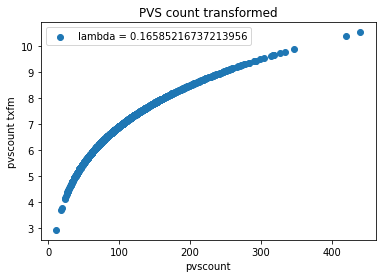

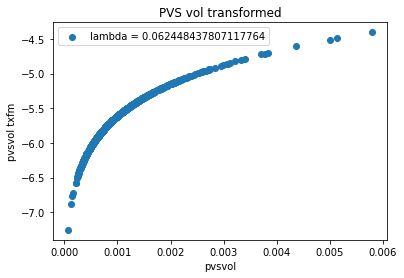

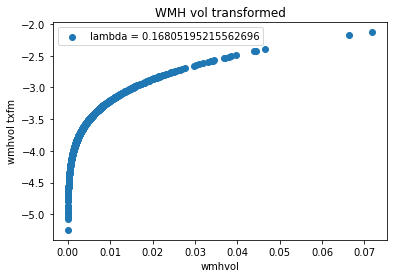

In [276]:
# plot transformed vs untransformed data, all

# pvscount vs pvscounttrans
plt.scatter(cs_report['pvscount'],cs_report['pvscounttrans'],label='lambda = '+str(countlam))
plt.title('PVS count transformed')
plt.xlabel('pvscount')
plt.ylabel('pvscount txfm')
plt.legend()
plt.show()
# icvnorm vs icvnormtrans
plt.scatter(cs_report['icvnorm'],cs_report['icvnormtrans'],label='lambda = '+str(icvlam))
plt.title('PVS vol transformed')
plt.xlabel('pvsvol')
plt.ylabel('pvsvol txfm')
plt.legend()
plt.show()
# wmhVOLnorm vs wmhVOLnormtrans
plt.scatter(cs_report['wmhVOLnorm'],cs_report['wmhVOLnormtrans'],label='lambda = '+str(wmhlam))
plt.title('WMH vol transformed')
plt.xlabel('wmhvol')
plt.ylabel('wmhvol txfm')
plt.legend()
plt.show()

In [277]:
# step 2: extract global stats in each group (mean, std)
## this is done before the transform

col = ['CN', 'MCI', 'AD']
index = ['# of subjects','mean PVS count', 'std PVS count', 'mean PVS volume', 'std PVS volume', 'mean PVS volume normed', 'std PVS volume normed']

subjcounts = [str(cn_cs.count()[0]),str(mci_cs.count()[0]),str(ad_cs.count()[0])]

mean_PVS_count = [cn_cs['pvscount'].mean(), mci_cs['pvscount'].mean(), ad_cs['pvscount'].mean()]
std_PVS_count = [cn_cs['pvscount'].std(), mci_cs['pvscount'].std(), ad_cs['pvscount'].std()]

mean_PVS_vol = [cn_cs['pvsvol'].mean(), mci_cs['pvsvol'].mean(), ad_cs['pvsvol'].mean()]
std_PVS_vol = [cn_cs['pvsvol'].std(), mci_cs['pvsvol'].std(), ad_cs['pvsvol'].std()]

mean_PVS_icvnorm = [cn_cs['icvnorm'].mean(), mci_cs['icvnorm'].mean(), ad_cs['icvnorm'].mean()]
std_PVS_icvnorm = [cn_cs['icvnorm'].std(), mci_cs['icvnorm'].std(), ad_cs['icvnorm'].std()]

statsall = pd.DataFrame([subjcounts,mean_PVS_count,std_PVS_count,mean_PVS_vol,std_PVS_vol,mean_PVS_icvnorm,std_PVS_icvnorm],index=index,columns=col)
statsall = statsall.style.set_caption('Summary: PVS')

# mean_PVS_countwm = [cn_cs['pvscountwm'].mean(), mci_cs['pvscountwm'].mean(), ad_cs['pvscountwm'].mean()]
# std_PVS_countwm = [cn_cs['pvscountwm'].std(), mci_cs['pvscountwm'].std(), ad_cs['pvscountwm'].std()]

# mean_PVS_volwm = [cn_cs['pvsvolwm'].mean(), mci_cs['pvsvolwm'].mean(), ad_cs['pvsvolwm'].mean()]
# std_PVS_volwm = [cn_cs['pvsvolwm'].std(), mci_cs['pvsvolwm'].std(), ad_cs['pvsvolwm'].std()]

# mean_PVS_icvnormwm = [cn_cs['icvnorm wm'].mean(), mci_cs['icvnorm wm'].mean(), ad_cs['icvnorm wm'].mean()]
# std_PVS_icvnormwm = [cn_cs['icv norm wm'].std(), mci_cs['icv norm wm'].std(), ad_cs['icv norm wm'].std()]

# statswm = pd.DataFrame([subjcounts,mean_PVS_countwm,std_PVS_countwm,mean_PVS_volwm,std_PVS_volwm,mean_PVS_icvnormwm,std_PVS_icvnormwm],index=index,columns=col)
# statswm = statswm.style.set_caption('Stats PVS WM')

statsall

,CN,MCI,AD
# of subjects,565,345,114
mean PVS count,111.662094,117.573865,130.177632
std PVS count,58.975606,64.994753,64.738897
mean PVS volume,1466.656395,1523.286281,1709.205402
std PVS volume,875.985826,921.122174,1008.041145
mean PVS volume normed,0.001012,0.001025,0.001149
std PVS volume normed,0.000613,0.000621,0.000627


In [278]:
# WMH
col = ['CN', 'MCI', 'AD']
index = ['# of subjects','mean WMH volume', 'std WMH volume', 'mean WMH volume normed', 'std WMH volume normed']

subjcounts = [str(cn_cs.count()[0]),str(mci_cs.count()[0]),str(ad_cs.count()[0])]

mean_WMH_vol = [cn_cs['wmhVOL'].mean(), mci_cs['wmhVOL'].mean(), ad_cs['wmhVOL'].mean()]
std_WMH_vol = [cn_cs['wmhVOL'].std(), mci_cs['wmhVOL'].std(), ad_cs['wmhVOL'].std()]

mean_WMH_icvnorm = [cn_cs['wmhVOLnorm'].mean(), mci_cs['wmhVOLnorm'].mean(), ad_cs['wmhVOLnorm'].mean()]
std_WMH_icvnorm = [cn_cs['wmhVOLnorm'].std(), mci_cs['wmhVOLnorm'].std(), ad_cs['wmhVOLnorm'].std()]

statsall = pd.DataFrame([subjcounts,mean_WMH_vol,std_WMH_vol,mean_WMH_icvnorm,std_WMH_icvnorm],index=index,columns=col)
statsall = statsall.style.set_caption('Summary: WMH')
statsall

,CN,MCI,AD
# of subjects,565,345,114
mean WMH volume,6891.998198,9713.936677,13743.943723
std WMH volume,10157.413059,12164.707032,15736.561108
mean WMH volume normed,0.004720,0.006338,0.008843
std WMH volume normed,0.006983,0.007351,0.009480


In [279]:
### putting things into a table
# 4 tables: wmh, pvs, and both transformed
# groups: cs_report, cn_cs, mci_cs, ad_cs

col = ['Shapiro-Wilks','Mann Whitney U','Kruskal Wallis','T-test','ANOVA']
tests = [stats.shapiro,stats.mannwhitneyu,stats.kruskal,stats.ttest_ind,stats.f_oneway]

pvsindex = ['pvscount-all', 'pvscount-cn/ad', 'pvscount-cn/mci', 'pvscount-cn/mci',
            'pvsvolnorm-all', 'pvsvolnorm-cn/ad', 'pvsvolnorm-cn/mci', 'pvsvolnorm-mci/ad',
            'pvscounttxfm-all', 'pvscounttxfm-cn/ad', 'pvscounttxfm-cn/mci', 'pvscounttxfm-mci/ad',
            'pvsvolnormtxfm-all', 'pvsvolnormtxfm-cn/ad', 'pvsvolnormtxfm-cn/mci', 'pvsvolnormtxfm-mci/ad']


pvsdatatype = ['pvscount','icvnorm','pvscounttrans','icvnormtrans']

basicstats = {}
for t,c in zip(tests,col):
    datatype = []
    basicstats[c] = datatype
    for d in pvsdatatype:
        if c == 'Shapiro-Wilks':
            data = [t(cs_report[d])[1],t(cn_cs[d])[1],t(mci_cs[d])[1],t(ad_cs[d])[1]]
            basicstats[c].extend(data)
        if c == 'Mann Whitney U' or c == 'T-test':
            data = [None,t(cn_cs[d],ad_cs[d])[1],t(mci_cs[d],cn_cs[d])[1],t(mci_cs[d],ad_cs[d])[1]]
            basicstats[c].extend(data)
        if c == 'Kruskal Wallis' or c == 'ANOVA':
            data = [t(cn_cs[d],ad_cs[d],mci_cs[d])[1],None,None,None]
            basicstats[c].extend(data)

#basicstats
basicstatsall = pd.DataFrame(data=basicstats,index=pvsindex,columns=col)
basicstatsall=basicstatsall.round(3)
basicstatsall.reset_index(inplace=True)
basicstatsall = basicstatsall.style.set_caption('Basic Stats: PVS')
basicstatsall

# ## plot


,index,Shapiro-Wilks,Mann Whitney U,Kruskal Wallis,T-test,ANOVA
0,pvscount-all,0.000000,nan,0.011000,nan,0.011000
1,pvscount-cn/ad,0.000000,0.002000,nan,0.003000,nan
2,pvscount-cn/mci,0.000000,0.294000,nan,0.159000,nan
3,pvscount-cn/mci,0.001000,0.046000,nan,0.073000,nan
4,pvsvolnorm-all,0.000000,nan,0.042000,nan,0.096000
5,pvsvolnorm-cn/ad,0.000000,0.012000,nan,0.031000,nan
6,pvsvolnorm-cn/mci,0.000000,0.900000,nan,0.770000,nan
7,pvsvolnorm-mci/ad,0.000000,0.028000,nan,0.066000,nan
8,pvscounttxfm-all,0.249000,nan,0.011000,nan,0.022000
9,pvscounttxfm-cn/ad,0.247000,0.002000,nan,0.004000,nan


In [280]:
# do the same for wmh
wmhindex = ['wmhvolnorm-all', 'wmhvolnorm-cn/ad', 'wmhvolnorm-cn/mci', 'wmhvolnorm-mci/ad', \
            'wmhvolnormtxfm-all', 'wmhvolnormtxfm-cn/ad', 'wmhvolnormtxfm-cn/mci', 'wmhvolnormtxfm-mci/ad',]
wmhdatatype = ['wmhVOLnorm','wmhVOLnormtrans']

basicstats = {}
for t,c in zip(tests,col):
    datatype = []
    basicstats[c] = datatype
    for d in wmhdatatype:
        if c == 'Shapiro-Wilks':
            data = [t(cs_report[d])[1],t(cn_cs[d])[1],t(mci_cs[d])[1],t(ad_cs[d])[1]]
            basicstats[c].extend(data)
        if c == 'Mann Whitney U' or c == 'T-test':
            data = [None,t(cn_cs[d],ad_cs[d])[1],t(mci_cs[d],cn_cs[d])[1],t(mci_cs[d],ad_cs[d])[1]]
            basicstats[c].extend(data)
        if c == 'Kruskal Wallis' or c == 'ANOVA':
            data = [t(cn_cs[d],ad_cs[d],mci_cs[d])[1],None,None,None]
            basicstats[c].extend(data)

basicstats
basicstatsall = pd.DataFrame(data=basicstats,index=wmhindex,columns=col)
basicstatsall=basicstatsall.round(3)
basicstatsall.reset_index(inplace=True)
basicstatsall = basicstatsall.style.set_caption('Basic Stats: WMH')
basicstatsall


,index,Shapiro-Wilks,Mann Whitney U,Kruskal Wallis,T-test,ANOVA
0,wmhvolnorm-all,0.000000,nan,0.000000,nan,0.000000
1,wmhvolnorm-cn/ad,0.000000,0.000000,nan,0.000000,nan
2,wmhvolnorm-cn/mci,0.000000,0.000000,nan,0.001000,nan
3,wmhvolnorm-mci/ad,0.000000,0.000000,nan,0.004000,nan
4,wmhvolnormtxfm-all,0.070000,nan,0.000000,nan,0.000000
5,wmhvolnormtxfm-cn/ad,0.513000,0.000000,nan,0.000000,nan
6,wmhvolnormtxfm-cn/mci,0.032000,0.000000,nan,0.000000,nan
7,wmhvolnormtxfm-mci/ad,0.880000,0.000000,nan,0.000000,nan


## Plot stats -- Cross Sectional

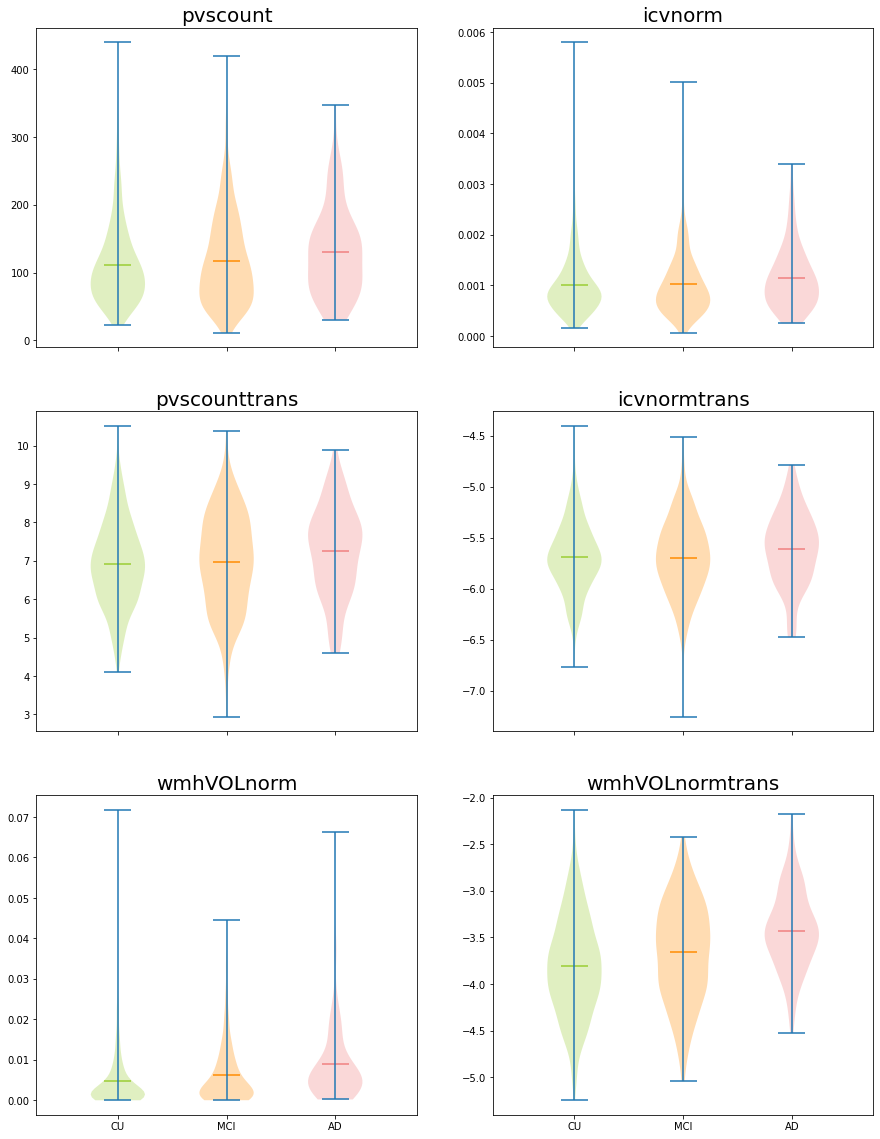

In [281]:
# step 6: plot stuff

#try: https://stackoverflow.com/questions/67376683/can-you-have-a-box-plot-overlap-a-half-violin-plot-on-a-raincloud-plot-using-pyt
#try: https://github.com/pog87/PtitPrince


# plots: (count, vol, count txfm, vol txfm);  (wmh, wmh txfm)

pvsdatatype = ['pvscount','icvnorm','pvscounttrans','icvnormtrans']
wmhdatatype = ['wmhVOLnorm','wmhVOLnormtrans']
datatype = pvsdatatype+wmhdatatype
titles = ['PVS Count', 'PVS Volume', 'PVS Count (txfm)', 'PVS Volume (txfm)','WMH Volume', 'WMH volume (txfm)']
fig, axs = plt.subplots(3, 2, figsize=(15, 20),sharex=True)
xlbl = ['CU','MCI','AD']

r = 0
c = 0

for d in datatype:
    axs[r,c].set_title(d,fontsize=20)
    data_to_plot = [cn_cs[d], mci_cs[d], ad_cs[d]]
    # Create the boxplot
    v = axs[r,c].violinplot(data_to_plot,positions=[1,2,3],showmeans=True,showextrema=True)
    # Set the color of the violin patches
    colors = ['yellowgreen', 'darkorange', 'lightcoral']
    for pc, color in zip(v['bodies'], colors):
        pc.set_facecolor(color)
    v['cmeans'].set_colors(colors)
    #axs[r,c].set_xticks(xlbl)
    if c==1:
        r+=1
        c=0
    else:
        c+=1


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels,fontsize=10)
    ax.set_xlim(0.25, len(labels) + 0.75)


set_axis_style(axs[2,0],xlbl)
set_axis_style(axs[2,1],xlbl)


#fig.ylabel(ylabel)

## Modeling: Cross-sectional


In [188]:
# modeling or something
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing 
import pandas as pd

115.71515299479165


ShapiroResult(statistic=0.9269222617149353, pvalue=6.557493491111342e-22)

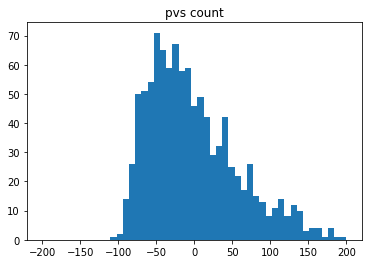

In [189]:
# distribution of residuals: example
icvnorm = cs_report['pvscount']
icvnorm_mean = np.mean(icvnorm)
print(icvnorm_mean)
res = (icvnorm-icvnorm_mean)
plt.hist(res, bins = np.linspace(-200, 200, 50))
plt.title('pvs count')
#plt.plot((icvnorm-icvnorm_mean))
stats.shapiro(res) # significantly not normal

In [190]:
# create a copy for modeling
cs_report_model = copy.deepcopy(cs_report)

# formate the dataframe
cs_report_model.rename(columns={'research group':'research_group'},inplace=True)

# replace categorical features with leveled variables
# idk why but only run this once
cs_report_model['research_group'] = cs_report_model['research_group'].map({'CN':1,'MCI':2,'AD':3})
cs_report_model['Sex'] = cs_report_model['Sex'].map({'F':2,'M':1})

data = cs_report_model[['pvscounttrans','icvnormtrans','wmhVOLnormtrans','Age','Sex','research_group','YrsEducation', 'Weight']]

In [191]:
cs_report_model.isna().any()

SubjectCodes       False
research_group     False
Age                False
Sex                False
Weight             False
VisitYear          False
YrsEducation       False
pvscount           False
pvsvol             False
icvnorm            False
wmVOL              False
wmVOLnorm          False
gmVOL              False
gmVOLnorm          False
wmhVOL             False
wmhVOLnorm         False
icv                False
icvnormtrans       False
pvscounttrans      False
wmhVOLnormtrans    False
dtype: bool

Fit to GLM to account for Age, Sex, Weight, etc.

Formulas:
- PVS ~ B0 + RG + confounds (age, sex, etc)
- WMH ~ B0 + RG + counfounds (age, sex, etc)

In [192]:
# # create formula and fit
# just research group
formula = "icvnormtrans ~ C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

formula = "pvscounttrans ~ C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

formula = "wmhVOLnormtrans ~ C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           icvnormtrans   No. Observations:                 1024
Model:                            GLM   Df Residuals:                     1021
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                         0.12751
Method:                          IRLS   Log-Likelihood:                -397.00
Date:                Tue, 23 Apr 2024   Deviance:                       130.19
Time:                        10:43:34   Pearson chi2:                     130.
No. Iterations:                     3   Pseudo R-squ. (CS):           0.005253
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -5

In [193]:
# just age+research group
formula = "icvnormtrans ~ Age + C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

formula = "pvscounttrans ~ Age + C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

formula = "wmhVOLnormtrans ~ Age + C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           icvnormtrans   No. Observations:                 1024
Model:                            GLM   Df Residuals:                     1020
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                         0.11793
Method:                          IRLS   Log-Likelihood:                -356.51
Date:                Tue, 23 Apr 2024   Deviance:                       120.29
Time:                        10:43:34   Pearson chi2:                     120.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08393
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -6

In [194]:
# all together: age and sex and research group
formula = "icvnormtrans ~ Age + C(Sex) + C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

formula = "pvscounttrans ~ Age + C(Sex) + C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

formula = "wmhVOLnormtrans ~ Age + C(Sex) + C(research_group)"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           icvnormtrans   No. Observations:                 1024
Model:                            GLM   Df Residuals:                     1019
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                         0.11788
Method:                          IRLS   Log-Likelihood:                -355.79
Date:                Tue, 23 Apr 2024   Deviance:                       120.12
Time:                        10:43:34   Pearson chi2:                     120.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08526
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -6

Text(0, 0.5, 'WMH volume')

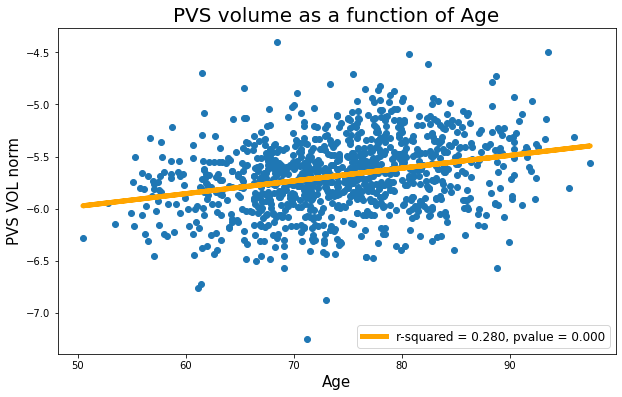

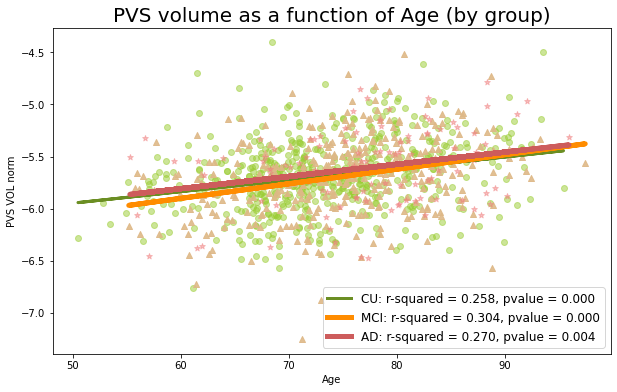

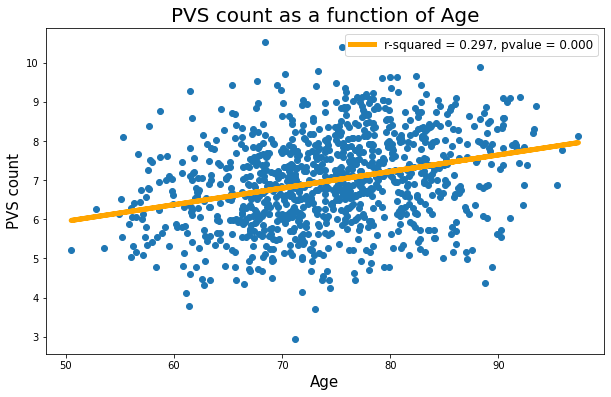

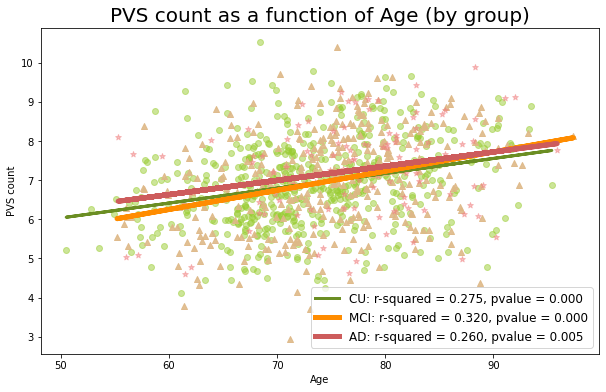

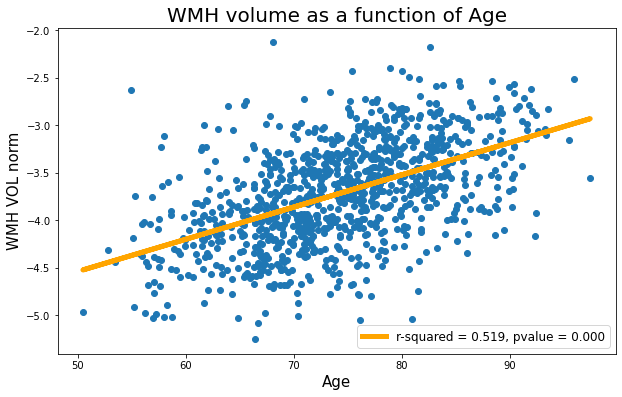

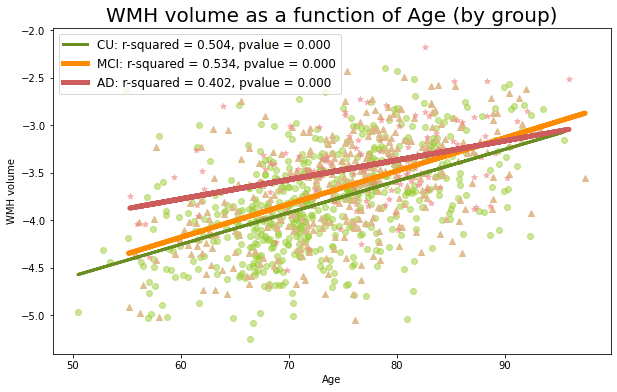

In [195]:
# GLM plots
# let's look at age?

x = cs_report_model['Age']
y = cs_report_model['icvnormtrans']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#fig,ax = plt.subplots(figsize=(10,5))
#m,b = np.polyfit(wmhvolnorm,icvnorm, 1)
figure = plt.figure(figsize=(10,6))
r=slope*x + intercept
plt.scatter(x,y)
#print(type(r_value))
#r = float(r)
rfmt = '{:.3f}'.format(r_value)
pfmt = '{:.3f}'.format(p_value)
plt.plot(x,r,c='orange',label='r-squared = '+rfmt+', ' 'pvalue = '+pfmt,linewidth=5)
#plt.ylim([-5.5, -3.5])
# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVS volume as a function of Age',fontsize=20)
plt.xlabel('Age',fontsize=15)
plt.ylabel('PVS VOL norm',fontsize=15)
# plt.ylim([-5.5,-3])


### variations by group
xcn = cn_cs['Age']
ycn = cn_cs['icvnormtrans']
xmci = mci_cs['Age']
ymci = mci_cs['icvnormtrans']
xad = ad_cs['Age']
yad = ad_cs['icvnormtrans']

slope, intercept, r_valuecn, p_valuecn, std_err = stats.linregress(xcn, ycn)
rcn=slope*xcn + intercept

slope, intercept, r_valuemci, p_valuemci, std_err = stats.linregress(xmci, ymci)
rmci=slope*xmci + intercept

slope, intercept, r_valuead, p_valuead, std_err = stats.linregress(xad, yad)
rad=slope*xad + intercept

figure = plt.figure(figsize=(10,6))

plt.scatter(xcn,ycn,c='yellowgreen',marker='o', alpha  = 0.5)
plt.scatter(xmci,ymci,c='burlywood',marker='^', alpha  = .9)
plt.scatter(xad,yad,c='lightcoral',marker='*', alpha  = 0.5)

plt.plot(xcn,rcn,c='olivedrab',linewidth=3,label='CU: r-squared = '+'{:.3f}'.format(r_valuecn)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuecn))
plt.plot(xmci,rmci,c='darkorange',linewidth=5,label='MCI: r-squared = '+'{:.3f}'.format(r_valuemci)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuemci))
plt.plot(xad,rad,c='indianred',linewidth=5,label='AD: r-squared = '+'{:.3f}'.format(r_valuead)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuead))

# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVS volume as a function of Age (by group)',fontsize=20)
plt.xlabel('Age',fontsize=10)
plt.ylabel('PVS VOL norm',fontsize=10)
##plt.ylim([-5.5,-3])



#### as functions of WMH and count
x = cs_report_model['Age']
y = cs_report_model['pvscounttrans']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#fig,ax = plt.subplots(figsize=(10,5))
#m,b = np.polyfit(wmhvolnorm,icvnorm, 1)
figure = plt.figure(figsize=(10,6))
r=slope*x + intercept
plt.scatter(x,y)
#print(type(r_value))
#r = float(r)
rfmt = '{:.3f}'.format(r_value)
pfmt = '{:.3f}'.format(p_value)
plt.plot(x,r,c='orange',label='r-squared = '+rfmt+', ' 'pvalue = '+pfmt,linewidth=5)
#plt.ylim([-5.5, -3.5])
# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVS count as a function of Age',fontsize=20)
plt.xlabel('Age',fontsize=15)
plt.ylabel('PVS count',fontsize=15)

### variations by group
xcn = cn_cs['Age']
ycn = cn_cs['pvscounttrans']
xmci = mci_cs['Age']
ymci = mci_cs['pvscounttrans']
xad = ad_cs['Age']
yad = ad_cs['pvscounttrans']

slope, intercept, r_valuecn, p_valuecn, std_err = stats.linregress(xcn, ycn)
rcn=slope*xcn + intercept

slope, intercept, r_valuemci, p_valuemci, std_err = stats.linregress(xmci, ymci)
rmci=slope*xmci + intercept

slope, intercept, r_valuead, p_valuead, std_err = stats.linregress(xad, yad)
rad=slope*xad + intercept

figure = plt.figure(figsize=(10,6))

plt.scatter(xcn,ycn,c='yellowgreen',marker='o', alpha  = 0.5)
plt.scatter(xmci,ymci,c='burlywood',marker='^', alpha  = .9)
plt.scatter(xad,yad,c='lightcoral',marker='*', alpha  = 0.5)

plt.plot(xcn,rcn,c='olivedrab',linewidth=3,label='CU: r-squared = '+'{:.3f}'.format(r_valuecn)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuecn))
plt.plot(xmci,rmci,c='darkorange',linewidth=5,label='MCI: r-squared = '+'{:.3f}'.format(r_valuemci)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuemci))
plt.plot(xad,rad,c='indianred',linewidth=5,label='AD: r-squared = '+'{:.3f}'.format(r_valuead)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuead))

# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVS count as a function of Age (by group)',fontsize=20)
plt.xlabel('Age',fontsize=10)
plt.ylabel('PVS count',fontsize=10)
#plt.ylim([-5.5,-3])

## wmh and age
x = cs_report_model['Age']
y = cs_report_model['wmhVOLnormtrans']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#fig,ax = plt.subplots(figsize=(10,5))
#m,b = np.polyfit(wmhvolnorm,icvnorm, 1)
figure = plt.figure(figsize=(10,6))
r=slope*x + intercept
plt.scatter(x,y)
#print(type(r_value))
#r = float(r)
rfmt = '{:.3f}'.format(r_value)
pfmt = '{:.3f}'.format(p_value)
plt.plot(x,r,c='orange',label='r-squared = '+rfmt+', ' 'pvalue = '+pfmt,linewidth=5)
##plt.ylim([-5.5, -3.5])
# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('WMH volume as a function of Age',fontsize=20)
plt.xlabel('Age',fontsize=15)
plt.ylabel('WMH VOL norm',fontsize=15)


### variations by group
xcn = cn_cs['Age']
ycn = cn_cs['wmhVOLnormtrans']
xmci = mci_cs['Age']
ymci = mci_cs['wmhVOLnormtrans']
xad = ad_cs['Age']
yad = ad_cs['wmhVOLnormtrans']

slope, intercept, r_valuecn, p_valuecn, std_err = stats.linregress(xcn, ycn)
rcn=slope*xcn + intercept

slope, intercept, r_valuemci, p_valuemci, std_err = stats.linregress(xmci, ymci)
rmci=slope*xmci + intercept

slope, intercept, r_valuead, p_valuead, std_err = stats.linregress(xad, yad)
rad=slope*xad + intercept

figure = plt.figure(figsize=(10,6))

plt.scatter(xcn,ycn,c='yellowgreen',marker='o', alpha  = 0.5)
plt.scatter(xmci,ymci,c='burlywood',marker='^', alpha  = .9)
plt.scatter(xad,yad,c='lightcoral',marker='*', alpha  = 0.5)

plt.plot(xcn,rcn,c='olivedrab',linewidth=3,label='CU: r-squared = '+'{:.3f}'.format(r_valuecn)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuecn))
plt.plot(xmci,rmci,c='darkorange',linewidth=5,label='MCI: r-squared = '+'{:.3f}'.format(r_valuemci)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuemci))
plt.plot(xad,rad,c='indianred',linewidth=5,label='AD: r-squared = '+'{:.3f}'.format(r_valuead)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuead))

# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('WMH volume as a function of Age (by group)',fontsize=20)
plt.xlabel('Age',fontsize=10)
plt.ylabel('WMH volume',fontsize=10)
#plt.ylim([-5.5,-3])



PVS vs WMH in cross-sectional data
Formulas:
- PVS ~ B0 + WMH (glm)
- PVS ~ B0 + WMH*RG (group: RG for intercept)
- PVS ~ B0 + WMH*RG + Age + Sex (group: RG for intercept)

In [196]:
# just wmh and pvs
formula = "pvscounttrans ~ wmhVOLnormtrans"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary()) 

formula = "icvnormtrans ~ wmhVOLnormtrans"
glmmodel = smf.glm(formula=formula, data=data).fit()
print(glmmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          pvscounttrans   No. Observations:                 1024
Model:                            GLM   Df Residuals:                     1022
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.0019
Method:                          IRLS   Log-Likelihood:                -1453.0
Date:                Tue, 23 Apr 2024   Deviance:                       1024.0
Time:                        10:43:35   Pearson chi2:                 1.02e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2985
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.1269      0.220     

In [197]:
# wmh and pvs correcting for age, sex
formula = "icvnormtrans ~ wmhVOLnormtrans + Age + C(Sex) "
lmemdl = smf.mixedlm(formula=formula,data=data,groups=data['research_group']).fit()
print(lmemdl.summary())

formula = "pvscounttrans ~ wmhVOLnormtrans + Age + C(Sex) "
lmemdl = smf.mixedlm(formula=formula,data=data,groups=data['research_group']).fit()
print(lmemdl.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: icvnormtrans
No. Observations:  1024    Method:             REML        
No. Groups:        3       Scale:              0.0973      
Min. group size:   114     Log-Likelihood:     -274.5212   
Max. group size:   565     Converged:          Yes         
Mean group size:   341.3                                   
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept       -4.650    0.164 -28.275 0.000 -4.973 -4.328
C(Sex)[T.2]      0.009    0.020   0.448 0.654 -0.030  0.048
wmhVOLnormtrans  0.318    0.022  14.612 0.000  0.275  0.361
Age              0.002    0.001   1.311 0.190 -0.001  0.005
Group Var        0.001    0.003                            

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pvscounttrans
N

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [198]:
# wmh and pvs compare across groups
#formula = "icvnormtrans ~ wmhVOLnormtrans + C(research_group)*wmhVOLnormtrans"
formula = "icvnormtrans ~ wmhVOLnormtrans*C(research_group)"
lmemdl = smf.mixedlm(formula=formula,data=data,groups=data['research_group']).fit()
print(lmemdl.summary())

formula = "pvscounttrans ~ wmhVOLnormtrans*C(research_group)"
lmemdl = smf.mixedlm(formula=formula,data=data,groups=data['research_group']).fit()
print(lmemdl.summary())

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         icvnormtrans
No. Observations:         1024            Method:                     REML        
No. Groups:               3               Scale:                      0.0971      
Min. group size:          114             Log-Likelihood:             -272.3772   
Max. group size:          565             Converged:                  Yes         
Mean group size:          341.3                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                              -4.531    0.326 -13.899 0.000 -5.170 -3.892
C(research_group)[T.2]                  0.188    0.466   0.403 0.687 -0.725  1.100
C(research_group)[T.3]     

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [199]:
# include age and sex
formula = "icvnormtrans ~ wmhVOLnormtrans*C(research_group) + Age + C(Sex)"
lmemdl = smf.mixedlm(formula=formula,data=data,groups=data['research_group']).fit()
print(lmemdl.summary())

formula = "pvscounttrans ~ wmhVOLnormtrans*C(research_group) + Age + C(Sex)"
lmemdl = smf.mixedlm(formula=formula,data=data,groups=data['research_group']).fit()
print(lmemdl.summary())

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         icvnormtrans
No. Observations:         1024            Method:                     REML        
No. Groups:               3               Scale:                      0.0972      
Min. group size:          114             Log-Likelihood:             -280.1849   
Max. group size:          565             Converged:                  Yes         
Mean group size:          341.3                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                              -4.721    0.358 -13.200 0.000 -5.422 -4.020
C(research_group)[T.2]                  0.184    0.466   0.396 0.692 -0.729  1.097
C(research_group)[T.3]     

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Text(0, 0.5, 'PVS VOL norm')

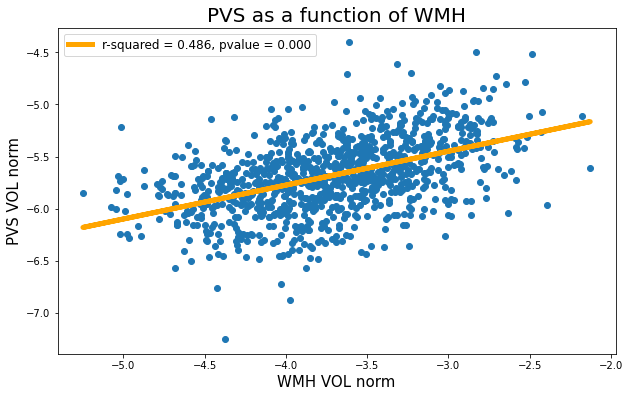

In [200]:
# plot wmh and pvs together

x = cs_report_model['wmhVOLnormtrans']
y = cs_report_model['icvnormtrans']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#fig,ax = plt.subplots(figsize=(10,5))
#m,b = np.polyfit(wmhvolnorm,icvnorm, 1)
figure = plt.figure(figsize=(10,6))
r=slope*x + intercept
plt.scatter(x,y)
#print(type(r_value))
#r = float(r)
rfmt = '{:.3f}'.format(r_value)
pfmt = '{:.3f}'.format(p_value)
plt.plot(x,r,c='orange',label='r-squared = '+rfmt+', ' 'pvalue = '+pfmt,linewidth=5)
# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVS as a function of WMH',fontsize=20)
plt.xlabel('WMH VOL norm',fontsize=15)
plt.ylabel('PVS VOL norm',fontsize=15)
# plt.grid()


(-6.0, -4.0)

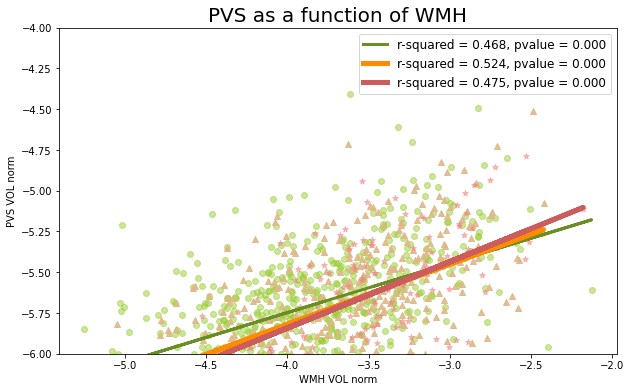

In [203]:
# variations by group
xcn = cn_cs['wmhVOLnormtrans']
ycn = cn_cs['icvnormtrans']
xmci = mci_cs['wmhVOLnormtrans']
ymci = mci_cs['icvnormtrans']
xad = ad_cs['wmhVOLnormtrans']
yad = ad_cs['icvnormtrans']

slope, intercept, r_valuecn, p_valuecn, std_err = stats.linregress(xcn, ycn)
rcn=slope*xcn + intercept

slope, intercept, r_valuemci, p_valuemci, std_err = stats.linregress(xmci, ymci)
rmci=slope*xmci + intercept

slope, intercept, r_valuead, p_valuead, std_err = stats.linregress(xad, yad)
rad=slope*xad + intercept

figure = plt.figure(figsize=(10,6))

plt.scatter(xcn,ycn,c='yellowgreen',marker='o', alpha  = 0.5)
plt.scatter(xmci,ymci,c='burlywood',marker='^', alpha  = .9)
plt.scatter(xad,yad,c='lightcoral',marker='*', alpha  = 0.5)

plt.plot(xcn,rcn,c='olivedrab',linewidth=3,label='r-squared = '+'{:.3f}'.format(r_valuecn)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuecn))
plt.plot(xmci,rmci,c='darkorange',linewidth=5,label='r-squared = '+'{:.3f}'.format(r_valuemci)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuemci))
plt.plot(xad,rad,c='indianred',linewidth=5,label='r-squared = '+'{:.3f}'.format(r_valuead)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuead))

# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVS as a function of WMH',fontsize=20)
plt.xlabel('WMH VOL norm',fontsize=10)
plt.ylabel('PVS VOL norm',fontsize=10)
plt.ylim([-6,-4])


## Extract Stats -- Longitudinal

- First pass: looking at the mean of each disease stage across 3 consecutive years
- Second pass: take all data and use LME to model

In [1001]:
# look at how many of each kinds of years there are
#report_clean.groupby('SubjectCodes').count().groupby('subjects').count() # 454 w 1tp, 257 w 2tp, 186 w 3tp

In [1002]:
# preliminary pass: 
# figure out how many of each kinds of years there are
# extract the subjects with 3 years listed
# group by research group

# counts = report_clean.groupby('SubjectCodes').count().reset_index()
# # yr3_group = report_clean.iloc[np.where(counts['subjects'] == 3)]
# # yr3_group
# yr3_subj = counts.iloc[np.where(counts['subjects'] == 3)]
# yr3_subj
# #report_clean.iloc[np.where(report_clean['SubjectCodes'] == yr3_subj['SubjectCodes'])]
# #report_clean
# # report_clean.iloc[np.where(report_clean['SubjectCodes'] == '002_S_4213')]
# report_cleantemp = copy.deepcopy(report_clean)
# lg3_report = report_cleantemp.merge(yr3_subj,how='inner',on='SubjectCodes')
# lg3_report
# #report_clean
# rggroupyr3 = lg3_report.groupby(['research group_x'])

# ad_lg = rggroupyr3.get_group('AD')
# mci_lg = rggroupyr3.get_group('MCI')
# cn_lg = rggroupyr3.get_group('CN')

# len(ad_lg)

In [1003]:
 # test how many of each kinds of years there are
#cn_lg.groupby(['VisitCodes_x']).count().sort_values(['VisitCodes_x'], ascending = False)

In [1004]:
# extract the subjects with consecutive years listed (y0,1,2)
# import re

# unique_groups_cn = cn_lg['SubjectCodes'].unique()
# grouped_cn = cn_lg.groupby(['SubjectCodes'])
# subjects_to_drop_cn = []
# for i in range(len(unique_groups_cn)):
#     group_check = grouped_cn.get_group(unique_groups_cn[i])
#     visit_codes = group_check['VisitCodes_x']

#     if any([(len(re.findall(r'y0[3456789]', i)) > 0)  for i in visit_codes]):
#         subjects_to_drop_cn.append(unique_groups_cn[i])

# unique_groups_mci = mci_lg['SubjectCodes'].unique()
# grouped_mci = mci_lg.groupby(['SubjectCodes'])
# subjects_to_drop_mci = []
# for i in range(len(unique_groups_mci)):
#     group_check = grouped_mci.get_group(unique_groups_mci[i])
#     visit_codes = group_check['VisitCodes_x']

#     if any([(len(re.findall(r'y0[3456789]', i)) > 0)  for i in visit_codes]):
#         subjects_to_drop_mci.append(unique_groups_mci[i])

# print(len(subjects_to_drop_mci))


In [1005]:
# # drop the ones that aren't consecutive
# # skipping AD bc there are so few subjects and the highest one it goes up to is 3

# cn_lgtemp = copy.deepcopy(cn_lg)
# for i in subjects_to_drop_cn:
#     ind = cn_lg[cn_lg['SubjectCodes'] == i].index
#     cn_lgtemp.drop(ind,inplace=True)
# print(cn_lgtemp['SubjectCodes'].nunique())

# mci_lgtemp = copy.deepcopy(mci_lg)
# for i in subjects_to_drop_mci:
#     ind = mci_lg[mci_lg['SubjectCodes'] == i].index
#     mci_lgtemp.drop(ind,inplace=True)
# print(mci_lgtemp['SubjectCodes'].nunique())


In [1006]:
# #### plot

# #cn
# grouped_yr_cn = cn_lgtemp.groupby(['VisitCodes_x'])
# y00_cn_mean = grouped_yr_cn.get_group('y00')['icvnorm_x'].mean()
# y01_cn_mean = grouped_yr_cn.get_group('y01')['icvnorm_x'].mean()
# y02_cn_mean = grouped_yr_cn.get_group('y02')['icvnorm_x'].mean()

# y00_cn_std = grouped_yr_cn.get_group('y00')['icvnorm_x'].std()
# y01_cn_std = grouped_yr_cn.get_group('y01')['icvnorm_x'].std()
# y02_cn_std = grouped_yr_cn.get_group('y02')['icvnorm_x'].std()

# # mci
# grouped_yr_mci = mci_lgtemp.groupby(['VisitCodes_x'])
# y00_mci_mean = grouped_yr_mci.get_group('y00')['icvnorm_x'].mean()
# y01_mci_mean = grouped_yr_mci.get_group('y01')['icvnorm_x'].mean()
# y02_mci_mean = grouped_yr_mci.get_group('y02')['icvnorm_x'].mean()

# y00_mci_std = grouped_yr_mci.get_group('y00')['icvnorm_x'].std()
# y01_mci_std = grouped_yr_mci.get_group('y01')['icvnorm_x'].std()
# y02_mci_std = grouped_yr_mci.get_group('y02')['icvnorm_x'].std()

# # ad
# grouped_yr_ad = ad_lg.groupby(['VisitCodes_x'])
# y00_ad_mean = grouped_yr_ad.get_group('y00')['icvnorm_x'].mean()
# y01_ad_mean = grouped_yr_ad.get_group('y01')['icvnorm_x'].mean()
# y02_ad_mean = grouped_yr_ad.get_group('y02')['icvnorm_x'].mean()

# y00_ad_std = grouped_yr_ad.get_group('y00')['icvnorm_x'].std()
# y01_ad_std = grouped_yr_ad.get_group('y01')['icvnorm_x'].std()
# y02_ad_std = grouped_yr_ad.get_group('y02')['icvnorm_x'].std()


# ## plot
# figure = plt.figure(figsize = (13,8))
# spacing_cn = [0,5,10]
# height_cn = [y00_cn_mean, y01_cn_mean, y02_cn_mean]
# yerr_cn = [y00_cn_std, y01_cn_std, y02_cn_std]

# spacing_mci = [1,6,11]
# height_mci = [y00_mci_mean, y01_mci_mean, y02_mci_mean]
# yerr_mci = [y00_mci_std, y01_mci_std, y02_mci_std]

# spacing_ad = [2,7,12]
# height_ad = [y00_ad_mean, y01_ad_mean, y02_ad_mean]
# yerr_ad = [y00_ad_std, y01_ad_std, y02_ad_std]


# barnames = ['year 0', 'year 1', 'year 2']
# plt.bar(spacing_cn, height_cn, yerr = yerr_cn, capsize = 15)
# plt.bar(spacing_mci, height_mci, yerr = yerr_mci, capsize = 15)
# plt.bar(spacing_ad, height_ad, yerr = yerr_ad, capsize = 15)

# plt.legend(['CN', 'MCI', 'AD'])
# tick_spacing = spacing_mci
# plt.xticks(tick_spacing, barnames, fontsize=15)
# plt.yticks(fontsize=15)

# plt.title('Longitudinal comparison of mean PVS vol',fontsize=20)



In [1007]:
# above plot is OK
# look at linear mixed effect models and code time as ind variable, interaction with timexdiagnosis,
# and if you are including wmh include as an independent variable and also include wmhxtime as a variable

# for glm, code the diagnosis as factors --> if you do that, you should get 2 additional numbers,
# which will compare CN to MCI and CN to AD

Try 2: using LME

In [1008]:
# format the columns and extract the data you need
lg_report = copy.deepcopy(report_clean)
lg_report.rename(columns={'research group': 'research_group'}, inplace=True)
#lg_report

In [1009]:
# transform cols for skew
# # transform for extreme skew
icvnormtransform,lam = boxcox(lg_report['icvnorm'])
lg_report['icvnormtrans'] = icvnormtransform
counttransform,lam = boxcox(lg_report['pvscount'])
lg_report['pvscounttrans'] = counttransform
wmhnormtransform,lam = boxcox(lg_report['wmhVOLnorm'])
lg_report['wmhVOLnormtrans'] = wmhnormtransform
lg_report

,subjects,research_group,ScanCode,SubjectCodes,ImageCodes,VisitCodes,pvscount,pvsvol,icvnorm,wmVOL,...,raw,WMH mask,Age,Weight,Sex,YrsEducation,VisitYear,icvnormtrans,pvscounttrans,wmhVOLnormtrans
0,ADNI3_002_S_0413y00_i863056,CN,ADNI3_002_S_0413y00,002_S_0413,i863056,y00,144.0,2099.0,0.001391,426501.0,...,no,yes,87.5,59.9,F,16.0,0,-4.295442,8.266601,-0.118034
1,ADNI3_002_S_4213y02_i1236679,CN,ADNI3_002_S_4213y02,002_S_4213,i1236679,y02,107.0,1057.0,0.000742,333915.0,...,no,yes,86.1,70.3,F,14.0,2,-4.534507,7.524432,-0.118034
2,ADNI3_002_S_6007y01_i988538,CN,ADNI3_002_S_6007y01,002_S_6007,i988538,y01,98.0,1170.0,0.000782,420716.0,...,no,yes,77.8,69.4,F,19.0,1,-4.515208,7.312771,-0.118034
3,ADNI3_002_S_1261y01_i989320,MCI,ADNI3_002_S_1261y01,002_S_1261,i989320,y01,196.0,2108.0,0.001472,372126.0,...,no,yes,82.3,61.2,F,16.0,1,-4.272938,9.082646,-0.118034
4,ADNI3_002_S_1261y02_i1270020,MCI,ADNI3_002_S_1261y02,002_S_1261,i1270020,y02,196.0,2313.0,0.001612,369423.0,...,no,yes,83.4,54.4,F,16.0,2,-4.236404,9.082646,-0.118034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,ADNI3_941_S_7051y00_i1553005,CN,ADNI3_941_S_7051y00,941_S_7051,i1553005,y00,149.0,1593.0,0.001076,399419.0,...,no,yes,63.7,72.6,M,12.0,0,-4.395888,8.354613,-0.118034
1089,ADNI3_941_S_7046y00_i1553931,CN,ADNI3_941_S_7046y00,941_S_7046,i1553931,y00,112.0,1572.0,0.001100,426638.0,...,no,yes,71.2,68.9,F,16.0,0,-4.387184,7.635856,-0.118034
1090,ADNI3_941_S_7085y00_i1600180,MCI,ADNI3_941_S_7085y00,941_S_7085,i1600180,y00,50.0,553.0,0.000413,380162.0,...,no,yes,69.7,100.2,F,12.0,0,-4.739412,5.803615,-0.118034
1091,ADNI3_941_S_7074y00_i1588331,CN,ADNI3_941_S_7074y00,941_S_7074,i1588331,y00,101.0,1211.0,0.000839,411080.0,...,no,yes,70.9,80.3,M,18.0,0,-4.489549,7.385013,-0.118034


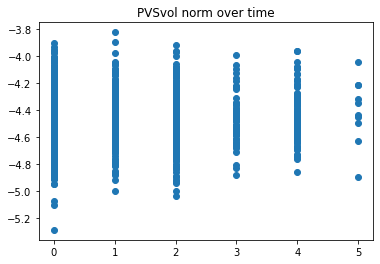

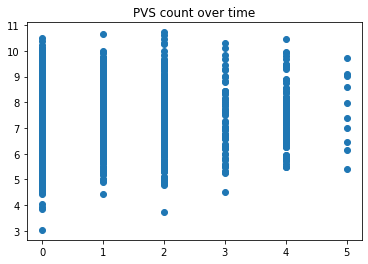

In [1012]:
# scatter plot
x=lg_report['VisitYear']
y=lg_report['icvnormtrans']
plt.scatter(x,y)
plt.title('PVSvol norm over time')
plt.show()

x=lg_report['VisitYear']
y=lg_report['pvscounttrans']
plt.scatter(x,y)
plt.title('PVS count over time')
plt.show()

In [1013]:
# create a report for modeling
lg_report_model = copy.deepcopy(lg_report)
lg_report_model = lg_report_model[['icvnormtrans','pvscounttrans','wmhVOLnormtrans','SubjectCodes','research_group','Age','Sex','VisitYear','YrsEducation','Weight']]
lg_report_model['research_group'] = lg_report_model['research_group'].map({'CN':1,'MCI':2,'AD':3})
lg_report_model['Sex'] = lg_report_model['Sex'].map({'F':2,'M':1})


In [1014]:
#### subject with no WMH: drop for now
lg_report_model.iloc[np.where(lg_report_model['wmhVOLnormtrans'].isna())[0]]
report_clean[report_clean['SubjectCodes']=='041_S_4271']
lg_report_model.drop(np.where(lg_report_model.isna())[0],inplace=True)
lg_report_model = lg_report_model.reset_index(drop=True)
lg_report_model[lg_report_model['SubjectCodes']=='041_S_4271']


,icvnormtrans,pvscounttrans,wmhVOLnormtrans,SubjectCodes,research_group,Age,Sex,VisitYear,YrsEducation,Weight
544,-4.660809,5.188351,-0.118034,041_S_4271,2,67.8,1,0,20.0,73.9
545,-4.457277,5.443068,-0.118034,041_S_4271,2,69.0,1,1,20.0,73.9


In [1015]:
# make slopes
#  icvnormtrans	pvscounttrans	wmhVOLnormtrans
lg_report_model_test = lg_report_model.reset_index()
maxyear = lg_report_model_test.groupby(['SubjectCodes']).max('VisitYear')['index']
minyear = lg_report_model_test.groupby(['SubjectCodes']).min('VisitYear')['index']
yr_max = lg_report_model_test.iloc[index_max,8].to_numpy()
yr_min = lg_report_model_test.iloc[index_min,8].to_numpy()
index_max = lg_report_model_test.groupby(['SubjectCodes']).max('VisitYear')['index']
index_min = lg_report_model_test.groupby(['SubjectCodes']).min('VisitYear')['index']

lg_report_model_slope_subset = lg_report_model_test.iloc[index_max]

vals_max = lg_report_model_test.iloc[index_max,0].to_numpy()
vals_min = lg_report_model_test.iloc[index_min,0].to_numpy()
slopes = (vals_max - vals_min) / (yr_max-yr_min)
lg_report_model_slope_subset['pvsvolrate'] = slopes


vals_max = lg_report_model_test.iloc[index_max,1].to_numpy()
vals_min = lg_report_model_test.iloc[index_min,1].to_numpy()
slopes2 = (vals_max - vals_min) / (yr_max-yr_min)
lg_report_model_slope_subset['pvscountrate'] = slopes2


vals_max = lg_report_model_test.iloc[index_max,2].to_numpy()
vals_min = lg_report_model_test.iloc[index_min,2].to_numpy()
slopes3 = (vals_max - vals_min) / (yr_max-yr_min)
lg_report_model_slope_subset['wmhvolrate'] = slopes3

lg_report_model_slope_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
lg_report_model_slope_subset.dropna(inplace=True)
lg_report_model_slope_subset.drop(['index'],axis=1,inplace=True)

lg_report_model_slope_subset.max() # contains inf


/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_57910/2819235900.py:15: RuntimeWarning: divide by zero encountered in divide
  slopes = (vals_max - vals_min) / (yr_max-yr_min)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_57910/2819235900.py:15: RuntimeWarning: invalid value encountered in divide
  slopes = (vals_max - vals_min) / (yr_max-yr_min)
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_57910/2819235900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lg_report_model_slope_subset['pvsvolrate'] = slopes
/var/folders/1b/13y0jzbx0r7d3rjhqvq1dwd80000gn/T/ipykernel_57910/2819235900.py:21: RuntimeWarning: divide by zero encountered in divide
  slopes2 = (vals_max - vals_min) / (yr_max-yr_min)
/var/folders/1

icvnormtrans        -3.825733
pvscounttrans       10.673978
wmhVOLnormtrans     -0.118034
SubjectCodes       941_S_6962
research_group              3
Age                      93.6
Sex                         2
VisitYear                   5
YrsEducation             20.0
Weight                  165.0
pvsvolrate          48.333333
pvscountrate         0.535348
wmhvolrate           3.019804
dtype: object

Formulas:
- PVS ~ B0 + time --> group = subject (base model: is there any relationship between PVS over time?)
- PVS ~ B0 + WMH*time --> group = subject (base model: does amount of WMH modulate and PVS over time?)
- PVS ~ B0 + WMH*time --> group = RG (is there any relationships between WMH and PVS over time in each group?)

Rate related equations:
- PVSrate ~ RG --> violin plot, KW/MWU
- PVSrate ~ WMHrate --> linear regression
- PVS/t ~ B0 + B1(WMH/t) --> group = RG,RG (is the change in PVS over time related to the change in WMH over time and is that different per group?)
- other:
    - PVS ~ B0 + WMH*RG*time --> group = RG
    - PVS/t ~ B0 + WMH/t + RG -- group = RG
      - idea: does RG influence the relationship between WMHrate and PVSrate? (i.e. if PVS increase over time also corresponds to WMH increase over time, does this stay the same across groups or are there different patterns across groups? If there are different patterns across groups, could mean there are separate mechanisms driving the patterns?)

- what does the interaction term mean again?
- RG as group instead of subjects for intercept?
- Documentation:
    - smf.mixedlm("Weight ~ Time", data, groups=data["Pig"], re_formula="~Time") ==== summary(lmer("Weight ~ Time + (1 + Time | Pig)" ,data=dietox))
    - "random slopes and intercepts for each pig with respect to time, since every pig may have a different starting rate and different weight change"
    - 


(which ones need to have a separate slope? what are you testing for?)

(everything above also corrected for age+sex after)




In [1016]:
# formula and model: just pvs and year
md = smf.mixedlm("pvscounttrans ~  VisitYear", lg_report_model, groups=lg_report_model["SubjectCodes"])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("icvnormtrans ~  VisitYear", lg_report_model, groups=lg_report_model["SubjectCodes"])
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pvscounttrans
No. Observations: 1092    Method:             REML         
No. Groups:       587     Scale:              0.2638       
Min. group size:  1       Log-Likelihood:     -1524.7271   
Max. group size:  6       Converged:          Yes          
Mean group size:  1.9                                      
------------------------------------------------------------
             Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    7.298     0.056  130.278  0.000   7.188   7.408
VisitYear    0.094     0.015    6.329  0.000   0.065   0.124
Group Var    1.568     0.293                                

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: icvnormtrans
No. Observations: 1092    Method:             REML        
No. Groups:       587     Scale:              0.0085      

In [1020]:
#formula and model: just pvs and year
md = smf.mixedlm("pvscounttrans ~  VisitYear", lg_report_model, groups=lg_report_model["research_group"])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("icvnormtrans ~  VisitYear", lg_report_model, groups=lg_report_model["research_group"])
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pvscounttrans
No. Observations: 1092    Method:             REML         
No. Groups:       3       Scale:              1.7856       
Min. group size:  160     Log-Likelihood:     -1875.3190   
Max. group size:  494     Converged:          No           
Mean group size:  364.0                                    
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     7.366     0.665  11.080  0.000   6.063   8.669
VisitYear     0.056     0.031   1.812  0.070  -0.005   0.116
Group Var     1.317                                         

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: icvnormtrans
No. Observations: 1092    Method:             REML        
No. Groups:       3       Scale:              0.0436      

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:

In [1021]:
# formula and model: just wmh and year
md = smf.mixedlm("pvscounttrans ~ VisitYear*wmhVOLnormtrans", lg_report_model, groups=lg_report_model['SubjectCodes'])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("icvnormtrans ~  VisitYear*wmhVOLnormtrans", lg_report_model, groups=lg_report_model['SubjectCodes'])
mdf = md.fit()
print(mdf.summary())

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:

                          Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           pvscounttrans
No. Observations:            1092              Method:                       REML         
No. Groups:                  587               Scale:                        0.2425       
Min. group size:             1                 Log-Likelihood:               -1469.5831   
Max. group size:             6                 Converged:                    No           
Mean group size:             1.9                                                          
------------------------------------------------------------------------------------------
                             Coef.       Std.Err.    z    P>|z|     [0.025       0.975]   
------------------------------------------------------------------------------------------
Intercept                  1784121.476 1053608.266  1.693 0.090   -280912.780  3849155.732
VisitYear                 

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:

                         Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          icvnormtrans
No. Observations:            1092             Method:                      REML        
No. Groups:                  587              Scale:                       0.0080      
Min. group size:             1                Log-Likelihood:              472.7033    
Max. group size:             6                Converged:                   No          
Mean group size:             1.9                                                       
---------------------------------------------------------------------------------------
                             Coef.      Std.Err.    z    P>|z|    [0.025       0.975]  
---------------------------------------------------------------------------------------
Intercept                  101834.003  134314.636  0.758 0.448  -161417.846  365085.851
VisitYear                  -52616.816   67155.090 -0.784 

In [1022]:
# formula and model: just wmh and year
md = smf.mixedlm("pvscounttrans ~ VisitYear*wmhVOLnormtrans", lg_report_model, groups=lg_report_model['research_group'])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("icvnormtrans ~  VisitYear*wmhVOLnormtrans", lg_report_model, groups=lg_report_model['research_group'])
mdf = md.fit()
print(mdf.summary())

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_

                           Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            pvscounttrans
No. Observations:            1092               Method:                        REML         
No. Groups:                  3                  Scale:                         1.7694       
Min. group size:             160                Log-Likelihood:                -1841.0942   
Max. group size:             494                Converged:                     No           
Mean group size:             364.0                                                          
--------------------------------------------------------------------------------------------
                              Coef.       Std.Err.     z    P>|z|     [0.025       0.975]   
--------------------------------------------------------------------------------------------
Intercept                   3080431.748  1522270.959  2.024 0.043     96835.493  6064028.003
Visit

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 1.735561
  warnings.warn(msg, ConvergenceWarning)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [1023]:
# formula and model: just wmh and year
md = smf.mixedlm("pvscounttrans ~ VisitYear*wmhVOLnormtrans + Age", lg_report_model, groups=lg_report_model['research_group'])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("icvnormtrans ~  VisitYear*wmhVOLnormtrans +Age", lg_report_model, groups=lg_report_model['research_group'])
mdf = md.fit()
print(mdf.summary())

                          Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           pvscounttrans
No. Observations:           1092              Method:                       REML         
No. Groups:                 3                 Scale:                        1.7016       
Min. group size:            160               Log-Likelihood:               inf          
Max. group size:            494               Converged:                    Yes          
Mean group size:            364.0                                                        
-----------------------------------------------------------------------------------------
                            Coef.      Std.Err.     z    P>|z|     [0.025       0.975]   
-----------------------------------------------------------------------------------------
Intercept                      1.338                                                     
VisitYear                  -8742.067

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWar

In [1024]:
# formula and model: just wmh and year
md = smf.mixedlm("pvscounttrans ~ VisitYear*wmhVOLnormtrans + Age + Sex", lg_report_model, groups=lg_report_model['research_group'])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("icvnormtrans ~  VisitYear*wmhVOLnormtrans +Age + Sex", lg_report_model, groups=lg_report_model['research_group'])
mdf = md.fit()
print(mdf.summary())

                          Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           pvscounttrans
No. Observations:           1092              Method:                       REML         
No. Groups:                 3                 Scale:                        1.6941       
Min. group size:            160               Log-Likelihood:               inf          
Max. group size:            494               Converged:                    Yes          
Mean group size:            364.0                                                        
-----------------------------------------------------------------------------------------
                            Coef.      Std.Err.     z    P>|z|     [0.025       0.975]   
-----------------------------------------------------------------------------------------
Intercept                      1.299                                                     
VisitYear                  -8460.186

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWar

Using Rate models

In [1027]:
lg_report_model_rate = copy.deepcopy(lg_report_model_slope_subset)
lg_report_model_rate['RG'] = lg_report_model_rate['research_group'].map({1:'CN',2:'MCI',3:'AD'})
lg_rate_grouped = lg_report_model_rate.groupby('RG')
cn_lgrate = lg_rate_grouped.get_group('CN')
mci_lgrate = lg_rate_grouped.get_group('MCI')
ad_lgrate = lg_rate_grouped.get_group('AD')

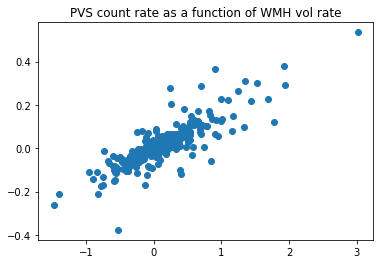

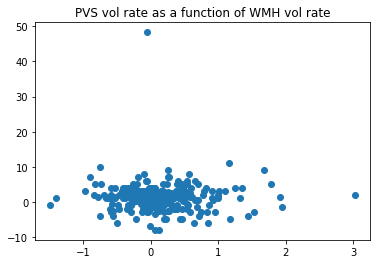

In [1028]:
# look at rate of PVS vs WMH
plt.scatter(lg_report_model_rate['wmhvolrate'],lg_report_model_rate['pvscountrate'])
plt.title('PVS count rate as a function of WMH vol rate')
plt.show()
plt.scatter(lg_report_model_rate['wmhvolrate'],lg_report_model_rate['pvsvolrate'])
plt.title('PVS vol rate as a function of WMH vol rate')
plt.show()


In [1029]:
# # do the same for wmh

# # col = ['Mann Whitney U','Kruskal Wallis','T-test','ANOVA']
# # tests = [stats.mannwhitneyu,stats.kruskal,stats.ttest_ind,stats.f_oneway]

# col = ['Mann Whitney U','Kruskal Wallis']
# tests = [stats.mannwhitneyu,stats.kruskal]

# index = ['wmhvolrate-all', 'wmhvolrate-cn/ad', 'wmhvolrate-cn/mci', 'wmhvolrate-mci/ad',
#             'pvsvolrate-all', 'pvsvolrate-cn/ad', 'pvsvolrate-cn/mci', 'pvsvolrate-mci/ad',
#             'pvscountrate-all', 'pvscountrate-cn/ad', 'pvscountrate-cn/mci', 'pvscountrate-mci/ad',
#             ]

# datatype = ['wmhvolrate','pvsvolrate','pvscountrate']



# lg_report_model_rate = copy.deepcopy(lg_report_model_slope_subset)
# lg_report_model_rate['RG'] = lg_report_model_rate['research_group'].map({1:'CN',2:'MCI',3:'AD'})
# lg_rate_grouped = lg_report_model_rate.groupby('RG')
# cn_lgrate = lg_rate_grouped.get_group('CN')
# mci_lgrate = lg_rate_grouped.get_group('MCI')
# ad_lgrate = lg_rate_grouped.get_group('AD')
# tests[1](ad_lgrate['wmhvolrate'],cn_lgrate['wmhvolrate'])[1]

# basicstats = {}
# for t,c in zip(tests,col):
#     datatype = []
#     basicstats[c] = datatype
#     for d in datatype:
#         if c == 'Mann Whitney U':
#             data = [None,t(cn_lgrate[d],ad_lgratecs[d])[1],t(mci_lgrate[d],cn_lgrate[d])[1],t(mci_lgrate[d],ad_lgrate[d])[1]]
#             basicstats[c].extend(data)
#         if c == 'Kruskal Wallis':
#             data = [t(cn_lgrate[d],ad_lgrate[d],mci_lgrate[d])[1],None,None,None]
#             basicstats[c].extend(data)
# basicstats
# # basicstatsall = pd.DataFrame(data=basicstats,index=index,columns=col)
# # basicstatsall=basicstatsall.round(3)
# # basicstatsall.reset_index(inplace=True)
# # basicstatsall = basicstatsall.style.set_caption('Basic Stats: Rates')
# # basicstatsall




datatype = ['wmhvolrate','pvsvolrate','pvscountrate']

for d in datatype:
    print('MWU ' + d + ': \n')
    print(stats.mannwhitneyu(cn_lgrate[d],ad_lgrate[d]))
    print(stats.mannwhitneyu(cn_lgrate[d],mci_lgrate[d]))
    print(stats.mannwhitneyu(mci_lgrate[d],ad_lgrate[d]))
    print('KW ' + d +': \n')
    print(stats.kruskal(cn_lgrate[d],ad_lgrate[d],ad_lgrate[d]))






MWU wmhvolrate: 

MannwhitneyuResult(statistic=2457.0, pvalue=0.05535458054318477)
MannwhitneyuResult(statistic=7983.0, pvalue=0.3366137197057957)
MannwhitneyuResult(statistic=2505.0, pvalue=0.22007898896827727)
KW wmhvolrate: 

KruskalResult(statistic=5.8908708178130205, pvalue=0.05257916139637877)
MWU pvsvolrate: 

MannwhitneyuResult(statistic=3079.0, pvalue=0.8919636879683154)
MannwhitneyuResult(statistic=7256.5, pvalue=0.03140396038860475)
MannwhitneyuResult(statistic=3203.0, pvalue=0.227911525489931)
KW pvsvolrate: 

KruskalResult(statistic=0.030267581855802743, pvalue=0.9849801493789412)
MWU pvscountrate: 

MannwhitneyuResult(statistic=2406.0, pvalue=0.0371122442575892)
MannwhitneyuResult(statistic=7640.0, pvalue=0.1284086670474393)
MannwhitneyuResult(statistic=2554.0, pvalue=0.29114800022246523)
KW pvscountrate: 

KruskalResult(statistic=6.971296025594149, pvalue=0.030633900836147185)


In [1030]:
# formula and model: PVSrate vs research group accounting fr age+sex
glmmodel = smf.glm("pvscountrate ~ C(research_group) + Age +C(Sex)", lg_report_model_rate).fit()
print(glmmodel.summary())

glmmodel = smf.glm("pvsvolrate ~ C(research_group) + Age +C(Sex)", lg_report_model_rate).fit()
print(glmmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           pvscountrate   No. Observations:                  307
Model:                            GLM   Df Residuals:                      302
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                       0.0087219
Method:                          IRLS   Log-Likelihood:                 294.79
Date:                Mon, 22 Apr 2024   Deviance:                       2.6340
Time:                        09:17:14   Pearson chi2:                     2.63
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04106
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

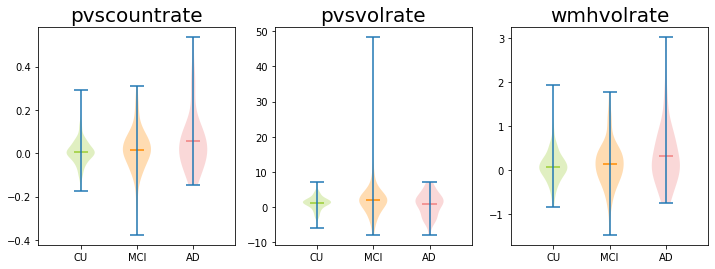

In [755]:
# plot pvs rate per group

pvsdatatype = ['pvscountrate','pvsvolrate']
wmhdatatype = ['wmhvolrate']
datatype = pvsdatatype+wmhdatatype
titles = ['PVS Count Rate', 'PVS Volume Rate', 'WMH Volume Rate']
fig, axs = plt.subplots(1, 3, figsize=(12, 4),sharex=True)
xlbl = ['CU','MCI','AD']

r = 0
c = 0

for d in datatype:
    axs[c].set_title(d,fontsize=20)
    data_to_plot = [cn_lgrate[d], mci_lgrate[d], ad_lgrate[d]]
    # Create the boxplot
    v = axs[c].violinplot(data_to_plot,positions=[1,2,3],showmeans=True,showextrema=True)
    # Set the color of the violin patches
    colors = ['yellowgreen', 'darkorange', 'lightcoral']
    for pc, color in zip(v['bodies'], colors):
        pc.set_facecolor(color)
    v['cmeans'].set_colors(colors)
    c+=1

    #axs[r,c].set_xticks(xlbl)


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels,fontsize=10)
    ax.set_xlim(0.25, len(labels) + 0.75)


set_axis_style(axs[1],xlbl)
#set_axis_style(axs[2,1],xlbl)


#fig.ylabel(ylabel)

In [739]:
# formula and model: visit year per research group
glmmodel = smf.glm("pvscountrate ~ wmhvolrate", lg_report_model_rate).fit()
print(glmmodel.summary())

lmmodel = smf.glm("pvsvolrate ~ wmhvolrate", lg_report_model_rate).fit()
print(glmmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           pvscountrate   No. Observations:                  307
Model:                            GLM   Df Residuals:                      305
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                       0.0025546
Method:                          IRLS   Log-Likelihood:                 481.76
Date:                Mon, 22 Apr 2024   Deviance:                      0.77915
Time:                        06:36:36   Pearson chi2:                    0.779
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9186
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0041      0.003     -1.362      0.1

In [1031]:
# formula and model: rates accounted for age + sex
glmmodel = smf.glm("pvscountrate ~ wmhvolrate + Age + C(Sex) + C(research_group)", lg_report_model_rate).fit()
print(glmmodel.summary())

lmmodel = smf.glm("pvsvolrate ~ wmhvolrate + Age + C(Sex) + C(research_group)", lg_report_model_rate).fit()
print(glmmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           pvscountrate   No. Observations:                  307
Model:                            GLM   Df Residuals:                      301
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                       0.0025535
Method:                          IRLS   Log-Likelihood:                 483.86
Date:                Mon, 22 Apr 2024   Deviance:                      0.76860
Time:                        09:20:48   Pearson chi2:                    0.769
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9197
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

LME models:

In [1032]:
# formula: PVSrate vs WMHrate with group RG
md = smf.mixedlm("pvsvolrate ~ wmhvolrate", lg_report_model_rate, groups=lg_report_model_rate["research_group"])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("pvscountrate ~ wmhvolrate", lg_report_model_rate, groups=lg_report_model_rate["research_group"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pvsvolrate
No. Observations: 307     Method:             REML      
No. Groups:       3       Scale:              15.0847   
Min. group size:  45      Log-Likelihood:     -852.3693 
Max. group size:  135     Converged:          Yes       
Mean group size:  102.3                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.278    0.346  3.690 0.000  0.599  1.956
wmhvolrate    -0.107    0.440 -0.242 0.808 -0.970  0.756
Group Var      0.174    0.084                           

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pvscountrate
No. Observations: 307     Method:             REML        
No. Groups:       3       Scale:              0.0026      
Min. group size:  45      Log-Likelihood:  

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:

(-10.0, 20.0)

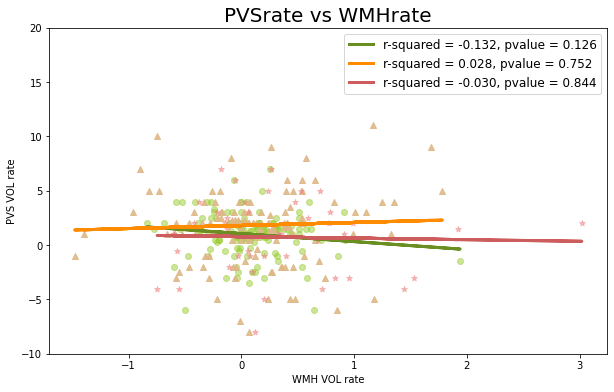

In [1033]:
# plot above

# variations by group
xcn = cn_lgrate['wmhvolrate']
ycn = cn_lgrate['pvsvolrate']
xmci = mci_lgrate['wmhvolrate']
ymci = mci_lgrate['pvsvolrate']
xad = ad_lgrate['wmhvolrate']
yad = ad_lgrate['pvsvolrate']

slope, intercept, r_valuecn, p_valuecn, std_err = stats.linregress(xcn, ycn)
rcn=slope*xcn + intercept

slope, intercept, r_valuemci, p_valuemci, std_err = stats.linregress(xmci, ymci)
rmci=slope*xmci + intercept

slope, intercept, r_valuead, p_valuead, std_err = stats.linregress(xad, yad)
rad=slope*xad + intercept

figure = plt.figure(figsize=(10,6))

plt.scatter(xcn,ycn,c='yellowgreen',marker='o', alpha  = 0.5)
plt.scatter(xmci,ymci,c='burlywood',marker='^', alpha  = .9)
plt.scatter(xad,yad,c='lightcoral',marker='*', alpha  = 0.5)

plt.plot(xcn,rcn,c='olivedrab',linewidth=3,label='r-squared = '+'{:.3f}'.format(r_valuecn)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuecn))
plt.plot(xmci,rmci,c='darkorange',linewidth=3,label='r-squared = '+'{:.3f}'.format(r_valuemci)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuemci))
plt.plot(xad,rad,c='indianred',linewidth=3,label='r-squared = '+'{:.3f}'.format(r_valuead)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuead))

# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVSrate vs WMHrate',fontsize=20)
plt.xlabel('WMH VOL rate',fontsize=10)
plt.ylabel('PVS VOL rate',fontsize=10)
plt.ylim([-10,20])


Text(0, 0.5, 'PVS count rate')

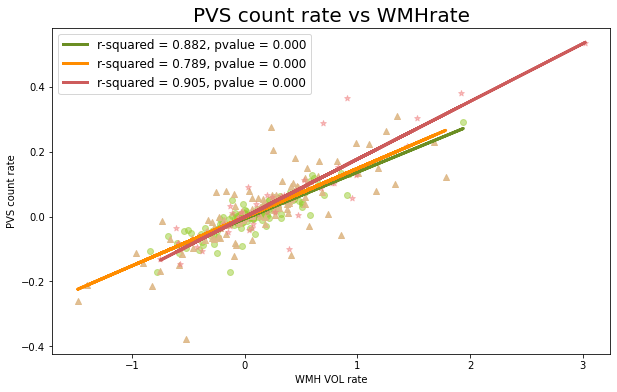

In [1034]:
# plot above

# variations by group
xcn = cn_lgrate['wmhvolrate']
ycn = cn_lgrate['pvscountrate']
xmci = mci_lgrate['wmhvolrate']
ymci = mci_lgrate['pvscountrate']
xad = ad_lgrate['wmhvolrate']
yad = ad_lgrate['pvscountrate']

slope, intercept, r_valuecn, p_valuecn, std_err = stats.linregress(xcn, ycn)
rcn=slope*xcn + intercept

slope, intercept, r_valuemci, p_valuemci, std_err = stats.linregress(xmci, ymci)
rmci=slope*xmci + intercept

slope, intercept, r_valuead, p_valuead, std_err = stats.linregress(xad, yad)
rad=slope*xad + intercept

figure = plt.figure(figsize=(10,6))

plt.scatter(xcn,ycn,c='yellowgreen',marker='o', alpha  = 0.5)
plt.scatter(xmci,ymci,c='burlywood',marker='^', alpha  = .9)
plt.scatter(xad,yad,c='lightcoral',marker='*', alpha  = 0.5)

plt.plot(xcn,rcn,c='olivedrab',linewidth=3,label='r-squared = '+'{:.3f}'.format(r_valuecn)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuecn))
plt.plot(xmci,rmci,c='darkorange',linewidth=3,label='r-squared = '+'{:.3f}'.format(r_valuemci)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuemci))
plt.plot(xad,rad,c='indianred',linewidth=3,label='r-squared = '+'{:.3f}'.format(r_valuead)+', '+ 'pvalue = ' '{:.3f}'.format(p_valuead))

# ax.annotate("r-squared = {:.3f}".format(r_value),(-2.4,-3.85),fontsize=12)
# ax.annotate("pvalue = {:.3f}".format(p_value),(-2.3,-3.95),fontsize=12)

plt.legend(fontsize=12)
plt.title('PVS count rate vs WMHrate',fontsize=20)
plt.xlabel('WMH VOL rate',fontsize=10)
plt.ylabel('PVS count rate',fontsize=10)
#plt.ylim([-10,20])


In [773]:
# formula and model: visit year * research group*time
md = smf.mixedlm("icvnormtrans ~ C(research_group)*wmhVOLnormtrans*VisitYear", lg_report_model, groups=lg_report_model["research_group"])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("pvscounttrans ~ C(research_group)*wmhVOLnormtrans*VisitYear", lg_report_model, groups=lg_report_model["research_group"])
mdf = md.fit()
print(mdf.summary())

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/base/model.py:

                                       Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    icvnormtrans
No. Observations:                    1092                       Method:                                REML        
No. Groups:                          3                          Scale:                                 0.0429      
Min. group size:                     160                        Log-Likelihood:                        244.4460    
Max. group size:                     494                        Converged:                             No          
Mean group size:                     364.0                                                                         
-------------------------------------------------------------------------------------------------------------------
                                                     Coef.       Std.Err.     z    P>|z|     [0.025       0.975

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [1035]:
# formula and model: visit year * research group
md = smf.mixedlm("pvsvolrate ~ wmhvolrate + C(research_group)", lg_report_model_rate, groups=lg_report_model_rate["research_group"])
mdf = md.fit()
print(mdf.summary())

md = smf.mixedlm("pvscountrate ~ wmhvolrate + C(research_group)", lg_report_model_rate, groups=lg_report_model_rate["research_group"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    pvsvolrate
No. Observations:     307        Method:                REML      
No. Groups:           3          Scale:                 15.0902   
Min. group size:      45         Log-Likelihood:        -850.0645 
Max. group size:      135        Converged:             Yes       
Mean group size:      102.3                                       
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept               1.004    3.899  0.257 0.797  -6.638  8.646
C(research_group)[T.2]  0.842    5.515  0.153 0.879  -9.966 11.651
C(research_group)[T.3] -0.245    5.535 -0.044 0.965 -11.094 10.604
wmhvolrate             -0.078    0.444 -0.177 0.860  -0.948  0.791
Group Var              15.090                                     

         

/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nanatang/anaconda3/envs/pvssegment/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [772]:
# formula and model: one of those above accounting for age/sex
# md = smf.mixedlm("icvnormtrans ~ Age + C(Sex) + VisitYear + C(research_group)*VisitYear + wmhVOLnormtrans*VisitYear", lg_report_model, groups=lg_report_model["SubjectCodes"])
# mdf = md.fit()
# print(mdf.summary())

## Plot Stats -- Longitudinal

In [ ]:
# move urplots down here

In [1660]:
# other things to play around with

# testing for linearity
#print(sm.stats.linear_rainbow(smf.glm(formula=formula, data=data).fit()))

#residuals ?

# plotting?
# can plot icv over yrs and color each group a different color, fit regression line that is based on all the corrected variablces (do ppl do that??)
